<a href="https://colab.research.google.com/github/MattJCR/Diffusion_in_Colab/blob/master/Multi_Model_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EASY STABLE DIFFUSION IMPLEMENTATION WITH MULTIPLE MODELS



*You need to configure GPU hardware accelerator to work properly*

In [76]:
!nvidia-smi

Tue Dec 27 13:15:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    30W /  70W |   8456MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Setup**
We install diffusion and several necessary libraries.
The ninja, xformer and triton libraries are to reduce memory consumption.


In [77]:
!pip install --upgrade diffusers transformers scipy accelerate
!pip install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html 
!pip install ninja xformers triton==2.0.0.dev20221120
XFORMERS_DISABLE_FLASH_ATTN=1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
#@title Model selector
model = "prompthero/openjourney" #@param ["CompVis/stable-diffusion-v1-4","runwayml/stable-diffusion-v1-5","stabilityai/stable-diffusion-2-1","dreamlike-art/dreamlike-diffusion-1.0","Linaqruf/anything-v3.0","prompthero/openjourney","prompthero/funko-diffusion","prompthero/linkedin-diffusion"]
# Import the required packages
from diffusers import StableDiffusionPipeline
import torch
import gc
import random
torch.cuda.empty_cache()
gc.collect()
print('torch:',torch.__version__)

# Create a StableDiffusionPipeline object and move it to a GPU
pipe = StableDiffusionPipeline.from_pretrained(model).to('cuda')
def dummy(images, **kwargs): return images, False 

torch: 1.13.0+cu116


Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

# **Stable Diffusion**

seed: -54671810081
model: prompthero/openjourney
size: (920, 512)


  0%|          | 0/100 [00:00<?, ?it/s]

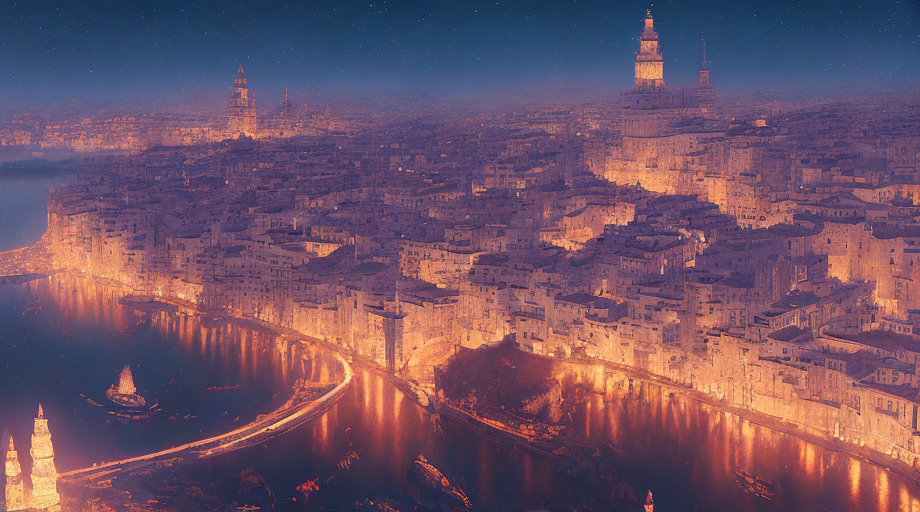

In [79]:
#@title Configuration { vertical-output: true, form-width: "50%" }
torch.cuda.empty_cache()
gc.collect()
# Set the number of inference steps to use
steps = 100 #@param {type:"slider", min:20, max:100, step:1}
# Define the text prompt
prompt = "a beautiful matte masterpiece of futuristic Granada Andalusia at night by atelier olschinsky and moebius, trending on artstation, featured on behance " #@param {type:"string"}
negative_prompt = "clean day"#@param {type:"string"}
#@markdown * Prompts examples in https://lexica.art/
# Define the seed prompt
seed = -54671810081 #@param {type:"raw"}
enable_NSFW = True #@param {type:"boolean"}
memory_reduction = True #@param {type:"boolean"}
#@markdown * If you have memory problems, enable memory reduction. (This has a huge impact on performance)
width = 920 #@param {type:"slider", min:640, max:1920, step:8}
height = 512 #@param {type:"slider", min:360, max:1080, step:8}
if memory_reduction:
  pipe.enable_attention_slicing()
if enable_NSFW:
  pipe.safety_checker = dummy
if seed == None:
  seed = random.randint(-99999999999,99999999999)
print('seed:',seed)
print('model:',model)
print('size:',(width,height))
# Set the random seed for deterministic output
generator = torch.Generator("cuda").manual_seed(seed)

# Generate the image
image = pipe(prompt, negative_prompt=negative_prompt, num_inference_steps=steps, generator=generator, width=width, height=height).images[0]
# image = pipe(prompt, num_inference_steps=steps).images[0]
image

# **Stable Diffusion IMG2IMG**

In [80]:
from diffusers import StableDiffusionImg2ImgPipeline
#del pipe
torch.cuda.empty_cache()
gc.collect()
#@title Model selector
model = "dreamlike-art/dreamlike-diffusion-1.0" #@param ["CompVis/stable-diffusion-v1-4","runwayml/stable-diffusion-v1-5","stabilityai/stable-diffusion-2-1","dreamlike-art/dreamlike-diffusion-1.0","Linaqruf/anything-v3.0","prompthero/openjourney","prompthero/funko-diffusion","prompthero/linkedin-diffusion"]
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model).to('cuda')

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

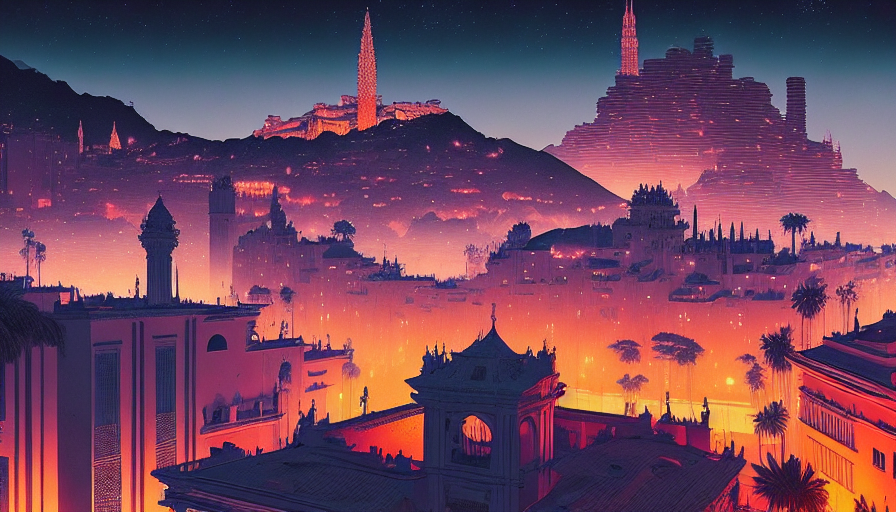

In [81]:
#@title IMG2IMG Configuration { vertical-output: true, form-width: "50%" }
steps = 100 #@param {type:"slider", min:20, max:100, step:1}
strength = 0.75 #@param {type:"slider", min:0.1, max:1, step:0.1}
guidance_scale = 7.5 #@param {type:"slider", min:1, max:20, step:0.5}
enable_NSFW = True #@param {type:"boolean"}
memory_reduction = True #@param {type:"boolean"}
if memory_reduction:
  pipe.enable_attention_slicing()
if enable_NSFW:
  pipe.safety_checker = dummy
torch.cuda.empty_cache()
gc.collect()
image = pipe(prompt=prompt, negative_prompt=negative_prompt, num_inference_steps=steps, init_image=image, strength=strength, guidance_scale=guidance_scale, generator=generator).images[0]
image

  0%|          | 0/25 [00:00<?, ?it/s]

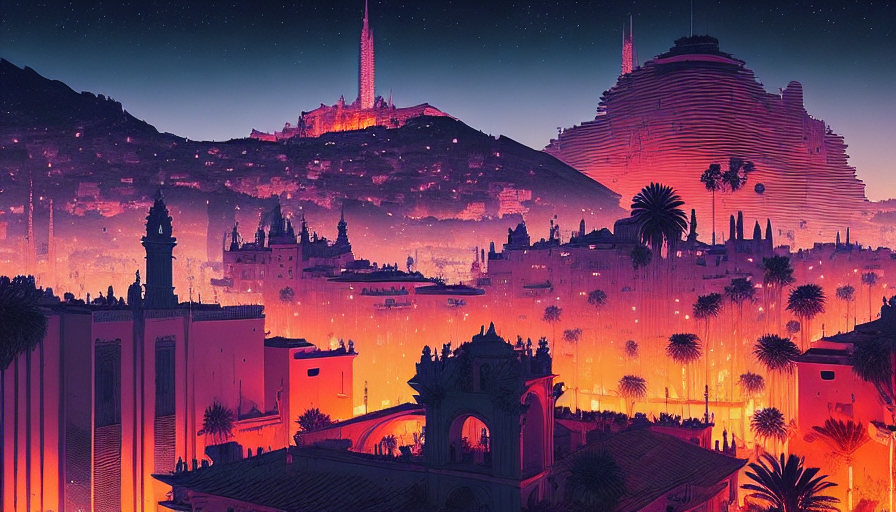

In [82]:
#@title IMG2IMG Configuration 2 { vertical-output: true, form-width: "50%" }
enable = True #@param {type:"boolean"}
steps = 100 #@param {type:"slider", min:20, max:100, step:1}
strength = 0.5 #@param {type:"slider", min:0.1, max:1, step:0.1}
guidance_scale = 7.5 #@param {type:"slider", min:1, max:20, step:0.5}
torch.cuda.empty_cache()
gc.collect()
if enable:
  image = pipe(prompt=prompt, negative_prompt=negative_prompt, init_image=image, strength=strength, guidance_scale=guidance_scale, generator=generator).images[0]
image

  0%|          | 0/37 [00:00<?, ?it/s]

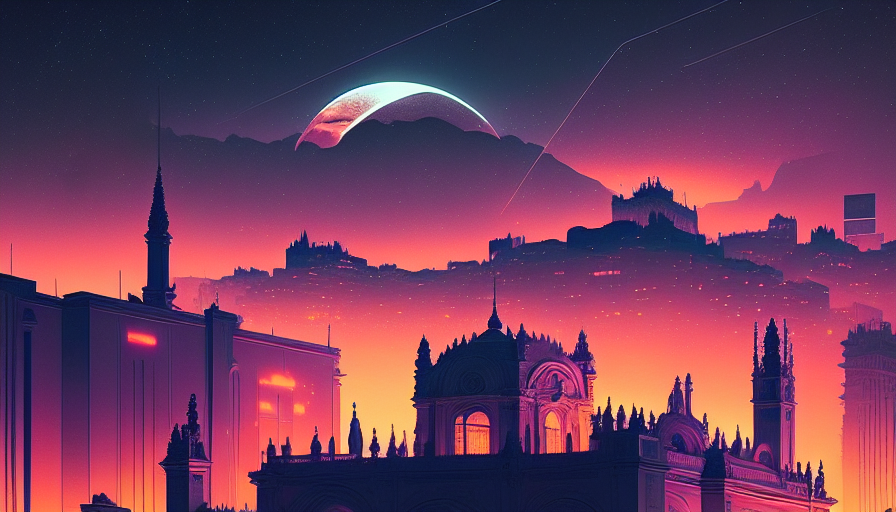

In [83]:
from diffusers import LMSDiscreteScheduler
#@title Schedule Configuration { vertical-output: true, form-width: "50%" }
enable = True #@param {type:"boolean"}
steps = 100 #@param {type:"slider", min:20, max:100, step:1}
strength = 0.5 #@param {type:"slider", min:0.1, max:1, step:0.1}
guidance_scale = 7.5 #@param {type:"slider", min:1, max:20, step:0.5}
torch.cuda.empty_cache()
gc.collect()
if enable:
  lms = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")
  pipe.scheduler = lms
  image = pipe(prompt=prompt, negative_prompt=negative_prompt, init_image=image, strength=0.75, guidance_scale=7.5, generator=generator).images[0]
image